# K- Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and recommendations

In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [397]:
retail_df=pd.read_csv("Online+Retail.csv",sep=",",encoding="ISO-8859-1",header=0)

### Reading the data set
retail_df.head(6)

In [398]:
retail_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [399]:
retail_df.info() # this gives info about type and no of rows and no of columns and all other required info
#Here we noticed customer id has less no of rows and description also missing few

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [400]:
retail_df.shape # which tells about no of rows and columns in the given data set

(541909, 8)

### Cleaning the data

In [401]:
# To find how many no(rows,columns) of missing values

In [402]:
#retail_df.isnull() - it will tell all the missing values as true
# If we want to count the no of missing values, we use below code to do so
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [403]:
# Now in above data , we have Customer id's are missing in large number and Descriptions also missing for few
# In order to find the percentage of these missing values we slighly modify the above code
100*(retail_df.isnull().sum())/len(retail_df)

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [404]:
round(100*(retail_df.isnull().sum())/len(retail_df),2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [405]:
# Drop all rows having missing values
retail_df=retail_df.dropna()

In [406]:
retail_df.shape

(406829, 8)

In [407]:
retail_df.tail(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France


### Prepare the data for modelling

-R (Recency): Number of days since last purchase made

-F (Frequency): Number of transactions

-M (Monetary): Total amount of transactions (revenue contributed by the customer)

In [408]:
# As we know that clustering is applied to integer values , here we have 3 such columns namely-quantitiy,unit price,date
#Finally we will get 
# Customer id  # Recency # Frequency #Monery value

In [409]:
# let's start with monetary column
retail_df['Monetary']=retail_df['Quantity']*retail_df["UnitPrice"]

In [410]:
retail_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [411]:
grouped_df=retail_df.groupby('CustomerID')['Monetary'].sum()
grouped_df=grouped_df.reset_index()
grouped_df.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [412]:
#Frequency
frequency=retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency=frequency.reset_index()
frequency.columns=['CustomerID','Frequency']
frequency.head(3)

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31


In [413]:
#Now that we have created two columns named as Monetary and Frequency 
#Let's Merge them to see them visually together
grouped_df=pd.merge(grouped_df,frequency,on='CustomerID',how='inner')

In [414]:
grouped_df.head(4)

,CustomerID,Monetary,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73


In [415]:
# Now we need to add Recency - ie how recently the individual has made a transaction with online store
#Convert recency to date time
# convert to datetime


In [416]:
# recency
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')
retail_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [417]:
#Computing the max date
max_date=max(retail_df["InvoiceDate"])
max_date

Timestamp('2011-12-09 12:50:00')

In [418]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [419]:
last_purchase=retail_df.groupby('CustomerID')['diff'].min()
last_purchase=last_purchase.reset_index()
last_purchase.head(3)

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00


In [420]:
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [421]:
grouped_df['recency']=grouped_df['recency'].dt.days

In [422]:
grouped_df.head(3)

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74


In [423]:
#While Data Preparation 
# We have to get rid of two problems namely 1.Outlier Treatment 2.Scaling of varaibles in order that all should be at same scale


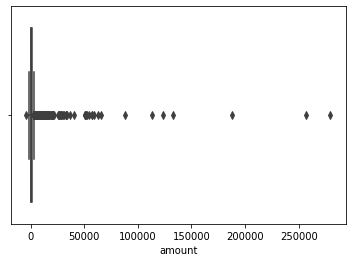

In [424]:
#Outliers
# 1.Statistical view
#2.Domain specific knowledge-Let's see one by one variable of outliers
# Monetary(amount)
sns.boxplot(grouped_df['amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x25d923b9288>,
 'caps': [<matplotlib.lines.Line2D at 0x25d923c2c48>,
 'boxes': [<matplotlib.lines.Line2D at 0x25d923b9ac8>],
 'medians': [<matplotlib.lines.Line2D at 0x25d923c2dc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x25d923c8c88>],
 'means': []}

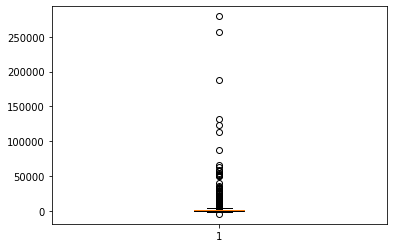

In [425]:
plt.boxplot(grouped_df['amount'])

In the above fig` few outliers are beyond 250000 - where in we can remove as per statistical view but check for domain knowledge as well to remove them`

{'whiskers': [<matplotlib.lines.Line2D at 0x25d9241cf48>,
 'caps': [<matplotlib.lines.Line2D at 0x25d92422e88>,
 'boxes': [<matplotlib.lines.Line2D at 0x25d9241cdc8>],
 'medians': [<matplotlib.lines.Line2D at 0x25d92428f88>],
 'fliers': [<matplotlib.lines.Line2D at 0x25d9242be08>],
 'means': []}

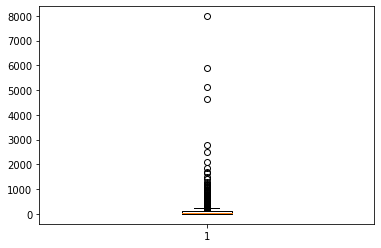

In [426]:
#Similarly check for Frequency and recency
plt.boxplot(grouped_df['frequency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x25d9248c648>,
 'caps': [<matplotlib.lines.Line2D at 0x25d92495ac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x25d92491108>],
 'medians': [<matplotlib.lines.Line2D at 0x25d9249ba48>],
 'fliers': [<matplotlib.lines.Line2D at 0x25d9249bb48>],
 'means': []}

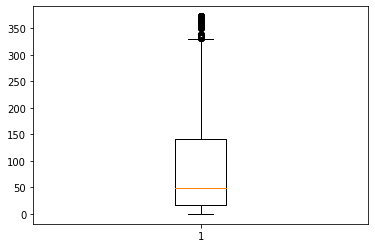

In [427]:
plt.boxplot(grouped_df['recency'])

In [428]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]


Here in this recency variable we see so many outliers beyond whisker level, they can be ignored directly as per statistical view

_**Rescaling or Standardization**_

In [429]:
rfm_df=grouped_df[['amount','frequency','recency']]

In [430]:
rfm_df.head(3)

,amount,frequency,recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74


In [431]:
scaler=StandardScaler()

In [432]:
rfm_df_scaled=scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

**Hopkins Test**

In [433]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [434]:
rfm_df_scaled=pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns=['amount','frequency','recency']

In [435]:
rfm_df_scaled.head(3)
#Here we have converted from array to data frame

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658


In [436]:
hopkins(rfm_df_scaled)
#Checking for hopkins score

0.9576483443005457

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

__** Now Comes Modelling part**__

### Modelling

In [437]:
kmeans=KMeans(n_clusters=4,max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [438]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [439]:
len(kmeans.labels_)

4293

### Finding the optimal number of Clusters

**SSD**

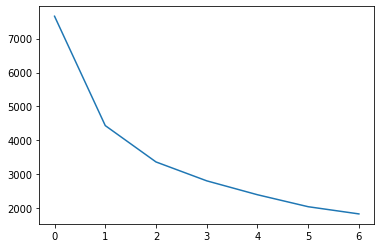

In [440]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

# Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [441]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.5411246404292333
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4800058803219165
For n_clusters=5, the silhouette score is 0.4662700564189704
For n_clusters=6, the silhouette score is 0.41760634878151304
For n_clusters=7, the silhouette score is 0.4158077420309644
For n_clusters=8, the silhouette score is 0.40958630945020674


In [442]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [443]:
kmeans.labels_

array([0, 2, 1, ..., 0, 1, 1])

In [444]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head(3)

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1


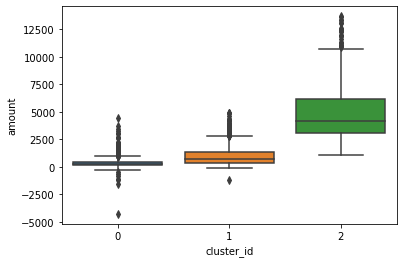

In [445]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

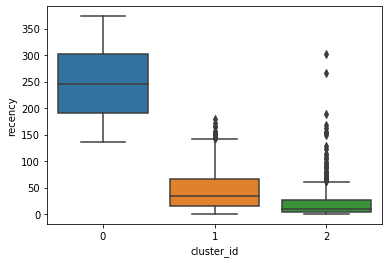

In [446]:
# plot
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

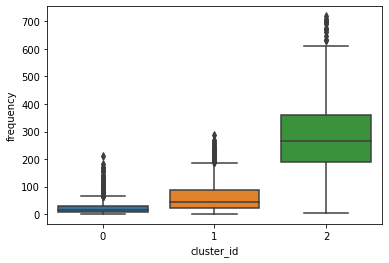

In [447]:
# plot
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

**These are the Entire Clustering method we follow whenever we do analysis for different data set**